In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, execute
from qiskit_ibm_provider import IBMProvider

from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Backend noise

We can simulate the noise in a real backend.

## Select the backend for the noise parameters

In [2]:
## If your account is not saved ahead
# IBMProvider.save_account("TOKEN")

provider = IBMProvider(instance='ibm-q/open/main') # use your own instance
name = 'ibm_brisbane'
backend = provider.get_backend(name)

## Circuit output without noise

`transpile` has option `optimization_level`. It will use classical pre-processing to shorten the depth of circuits. It has 4 levels: 0, 1, 2, and 3. `0` means no optimization. `1` is the fastest one with smallest effects. Level `2` and '3' consume much more time in pre-processing. For details, check https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/preset_passmanagers 

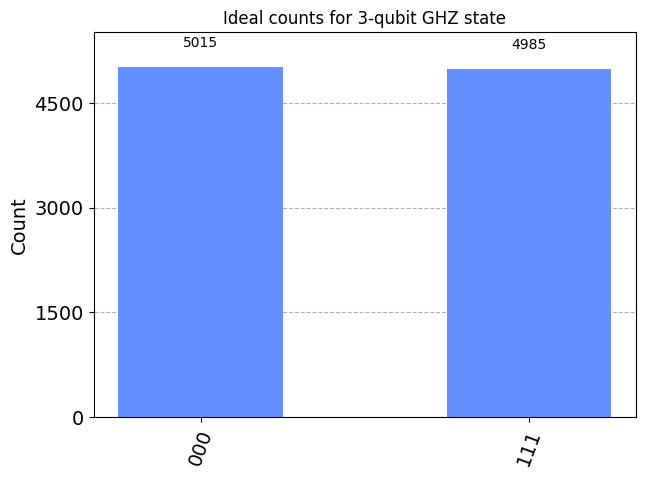

In [3]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal, seed_transpiler=7, optimization_level=0), shots=10000).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

## Apply noise parameters to a simulator

In [4]:
noise_sim = AerSimulator.from_backend(backend)

## Check noisy outputs

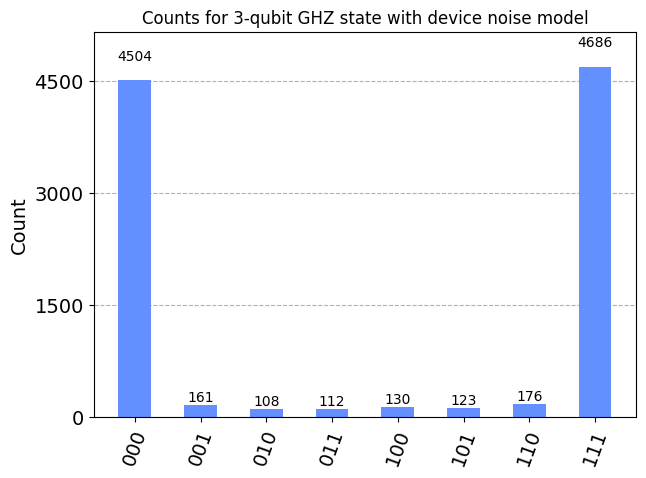

In [5]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, noise_sim, seed_transpiler=7, optimization_level=0)


# Execute noisy simulation and get counts
result_noise = noise_sim.run(tcirc, shots=10000).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

# Individual noise model

We can only add a specific noise channel into a specific gate. For details, see https://qiskit.org/ecosystem/aer/tutorials/3_building_noise_models.html

We first need to see what basis gates that a real IBMQ backend is use

In [6]:
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

## Add depolarization noise channel

We only add a depolarizing error into `X` and `id` gates in all qubits, and add a thermal relaxation error into 'sx' gate in qubit `0`. For details about `NoiseModel`, check https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.NoiseModel.html#qiskit_aer.noise.NoiseModel

In [7]:
# Create an empty noise model
noise_model = NoiseModel(basis_gates=['ecr', 'id', 'rz', 'sx', 'x'])

# Add depolarizing error to all single qubit u1, u2, u3 gates
error_all_qubit = depolarizing_error(0.05, 1) # param, num_qubits
error_single = thermal_relaxation_error(100,200, 10) # t1, t2, gate time, excited_state_population=0

## Gate noise
## Add to all qubits
noise_model.add_all_qubit_quantum_error(error_all_qubit, ['x', 'id'])
## Add to a specific qubits
noise_model.add_quantum_error(error_single, ['sx'], [0])


## Measure error
# Measurement miss-assignement probabilities
p0given1 = 0.1   # Pr(Meas 0 | Given 1)
p1given0 = 0.05  # Pr(Meas 1 | Given 0)
error_meas = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
noise_model.add_all_qubit_readout_error(error_meas)
# also use add_readout_error for individual qubits.

print(noise_model)

NoiseModel:
  Basis gates: ['ecr', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'sx', 'measure']
  Qubits with noise: [0]
  All-qubits errors: ['x', 'id', 'measure']
  Specific qubit errors: [('sx', (0,))]


## Put the custom noise model into a simulator

Note that the specified basis gates in `NoiseModel` will overwrite corresponding ones in `AerSimulator`.

In [8]:
sim_noise = AerSimulator(noise_model=noise_model) #
sim_noise.configuration().basis_gates

['ecr',
 'id',
 'rz',
 'sx',
 'x',
 'break_loop',
 'continue_loop',
 'for_loop',
 'if_else',
 'kraus',
 'qerror_loc',
 'quantum_channel',
 'roerror',
 'save_amplitudes',
 'save_amplitudes_sq',
 'save_clifford',
 'save_density_matrix',
 'save_expval',
 'save_expval_var',
 'save_matrix_product_state',
 'save_probabilities',
 'save_probabilities_dict',
 'save_stabilizer',
 'save_state',
 'save_statevector',
 'save_statevector_dict',
 'save_superop',
 'save_unitary',
 'set_density_matrix',
 'set_matrix_product_state',
 'set_stabilizer',
 'set_statevector',
 'set_superop',
 'set_unitary',
 'superop',
 'while_loop']

## Run the circuit

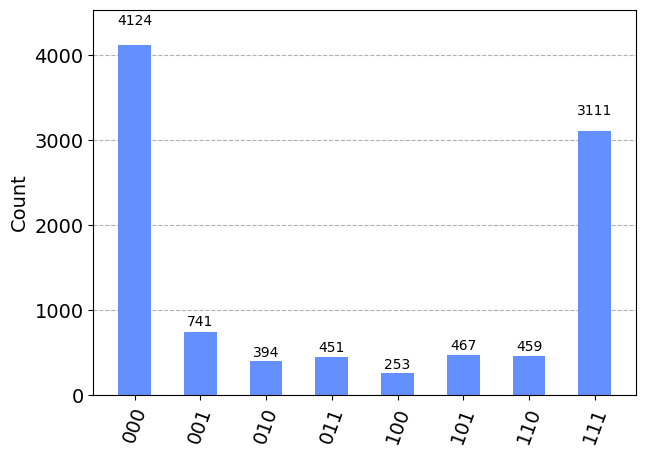

In [9]:
# Transpile circuit for noisy basis gates
tcirc2 = transpile(circ, noise_sim, seed_transpiler=7, optimization_level=0)

# Run and get counts
result_custom_noise = sim_noise.run(tcirc2, shots=10000).result()
counts_custom_noise = result_custom_noise.get_counts(0)

# Plot noisy output
plot_histogram(counts_custom_noise)

## Effects of different noise levels

In [10]:
model_list = []
for i in range(5):
    # Create an empty noise model
    noise_model = NoiseModel(basis_gates=['ecr', 'id', 'rz', 'sx', 'x'])

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error_all_qubit = depolarizing_error(0.05*i+0.05, 1) # param, num_qubits
    noise_model.add_all_qubit_quantum_error(error_all_qubit, ['x', 'id', 'sx'])

    model_list.append(noise_model)

In [11]:
for j in range(len(model_list)):
    nm = model_list[j]
    sim_noise = AerSimulator(noise_model=nm) #
    
    # Run and get counts
    result_custom_noise = sim_noise.run(tcirc2, shots=10000).result()
    counts_custom_noise = result_custom_noise.get_counts(0)
    
    # Plot noisy output
    print('Depolarizing noise level: {:.2f}'.format(0.05*j+0.05),
          ',   Counts of 000:', counts_custom_noise['000'], 
          ',   Counts of 111:', counts_custom_noise['111'])

Depolarizing noise level: 0.05 ,   Counts of 000: 3823 ,   Counts of 111: 3921
Depolarizing noise level: 0.10 ,   Counts of 000: 3012 ,   Counts of 111: 3011
Depolarizing noise level: 0.15 ,   Counts of 000: 2447 ,   Counts of 111: 2379
Depolarizing noise level: 0.20 ,   Counts of 000: 2025 ,   Counts of 111: 2094
Depolarizing noise level: 0.25 ,   Counts of 000: 1755 ,   Counts of 111: 1700


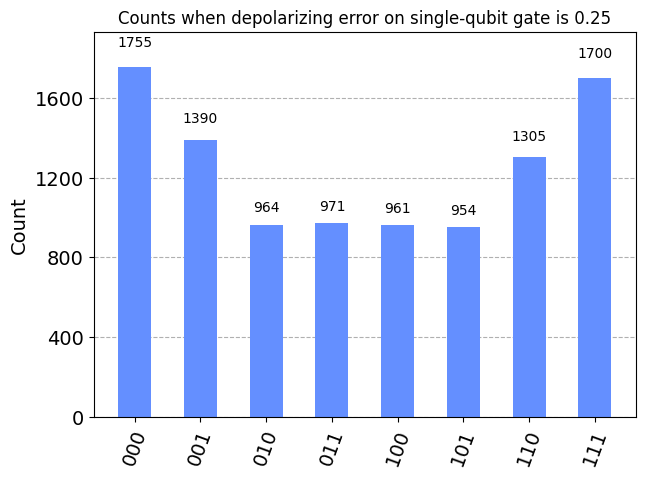

In [13]:
plot_histogram(counts_custom_noise,  title='Counts when depolarizing error on single-qubit gate is 0.25')